In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time
from pathlib import Path

from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd

from tqdm import tqdm_notebook

In [4]:
pj_dir = Path(os.getcwd()).parents[0]
data_dir = pj_dir/'data'
img_dir = pj_dir/'images'
src_dir = pj_dir/'change-detection/src'
sys.path.append(str(src_dir))

In [58]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["font.family"] = "IPAexGothic"
import logging
logging.basicConfig(level=logging.INFO)

# Section 0

In [11]:
from change_detector import ChangeDetector

## change detector

In [16]:
detector = ChangeDetector()

In [17]:
print(detector.signal_size)
next(detector.step(10)); 
print(detector.signal_size)

0
1


## online simulator

In [33]:
from change_detector import OnlineSimulator

In [52]:
signal = np.random.randint(10, size=20)
print(f"Signal: {signal}")

Signal: [0 7 3 4 9 1 5 5 7 4 1 2 7 1 8 5 9 1 5 0]


Residuals: []
Stopping rule not triggered.


False

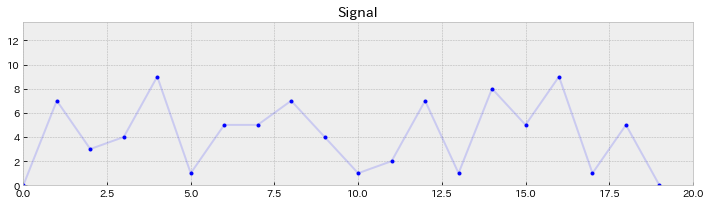

In [53]:
detector = ChangeDetector()
sim = OnlineSimulator(detector, signal)
sim.run(plot=True)

In [54]:
class MeanDetector(ChangeDetector):
    def __init__(self):
        super().__init__()
        self.total_val = 0
        self.mean_ = np.nan
        
    def update_residuals(self, new_signal_value):
        self._update_base_residuals(new_signal_value)
        
        self.total_val += new_signal_value
        self.mean_ = self.total_val / self.signal_size
        
    def check_stopping_rules(self, new_signal_value):
        if np.abs(new_signal_value - self.mean_) > 100:
            self.rules_triggered = True

Residuals: ['mean_']
Stopping rule not triggered.


False

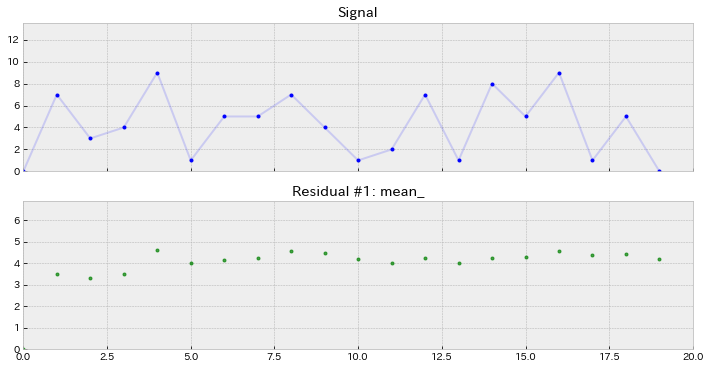

In [55]:
detector = MeanDetector()
sim = OnlineSimulator(detector, signal)
sim.run(plot=True)

Residuals: ['mean_']
Change detected. Stopping Rule triggered at 17.



True

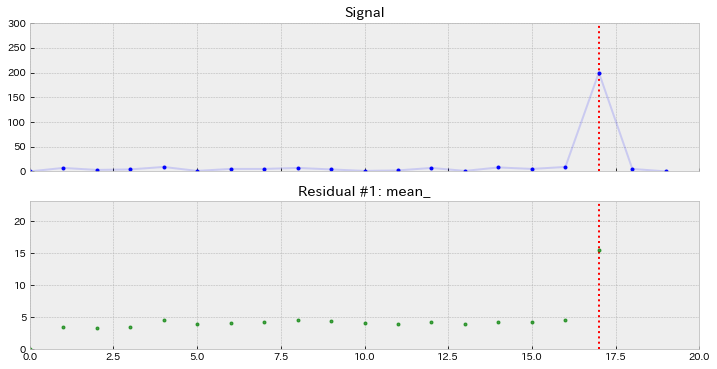

In [56]:
signal[17] = 200
detector = MeanDetector()
sim = OnlineSimulator(detector, signal)
sim.run(plot=True)

# Section 1

Text(0.5,1,'An example signal')

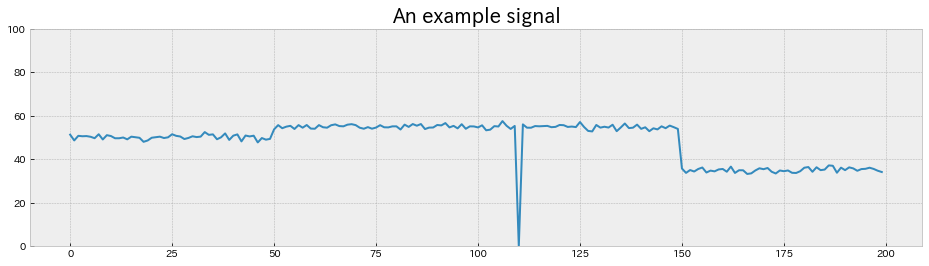

In [60]:
signal = np.random.normal(scale=1, size=200)
signal[:50] += 50; signal[50:] += 55; signal[150:] -= 20
signal[110] = 0

plt.plot(signal)
plt.ylim(0,100)
plt.title("An example signal", fontsize=20)

## Broken trend or seasonality

Text(0.5,1,'Example: Directory Assistance Calls')

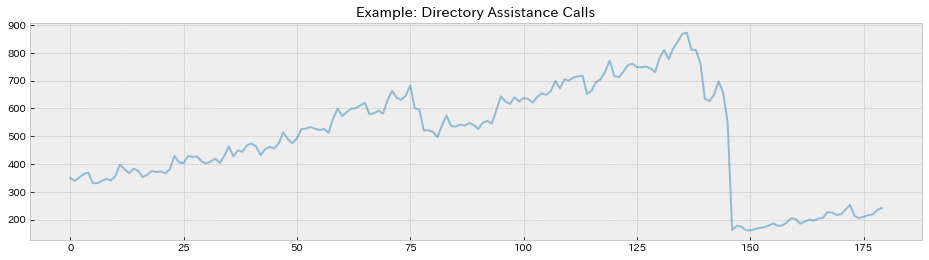

In [61]:
signal = [350,339,351,364,369,331,331,340,346,341,357,398,381,367,383,375,353,361,375,371,373,366,382,429,406,403,429,425,427,409,402,409,419,404,429,463,428,449,444,467,474,463,432,453,462,456,474,514,489,475,492,525,527,533,527,522,526,513,564,599,572,587,599,601,611,620,579,582,592,581,630,663,638,631,645,682,601,595,521,521,516,496,538,575,537,534,542,538,547,540,526,548,555,545,594,643,625,616,640,625,637,634,621,641,654,649,662,699,672,704,700,711,715,718,652,664,695,704,733,772,716,712,732,755,761,748,748,750,744,731,782,810,777,816,840,868,872,811,810,762,634,626,649,697,657,549,162,177,175,162,161,165,170,172,178,186,178,178,189,205,202,185,193,200,196,204,206,227,225,217,219,236,253,213,205,210,216,218,235,241]
plt.plot(signal, alpha = 0.5)
plt.title('Example: Directory Assistance Calls')

### Abberation in periodicity

Text(0.5,1,'Example: periodic signal anomaly')

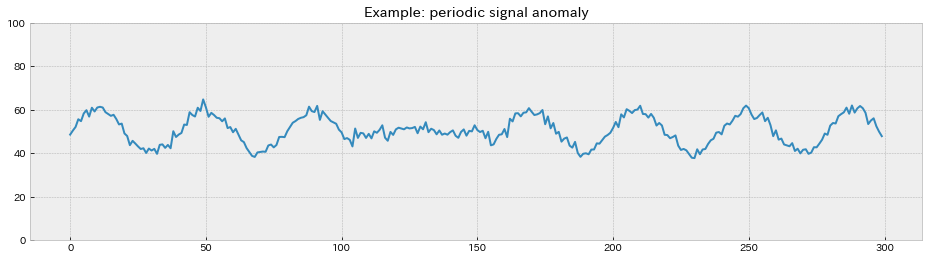

In [62]:
signal = np.sin(np.linspace(0, 15*np.pi, num=300))
signal[105:155] *= 0.1
signal = 10 * signal + 50

noise = np.random.normal(scale = 1.5, size=300)
signal = signal + noise

plt.ylim(0,100)
plt.plot(signal)
plt.title('Example: periodic signal anomaly')

# Section 2

Text(0.5,1,'sig1 : A trivial signal')

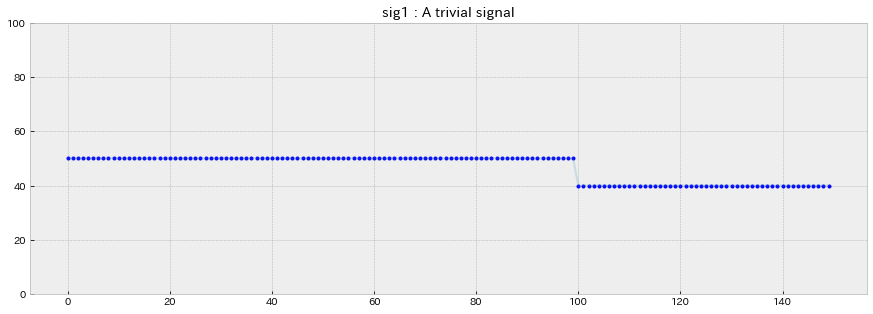

In [63]:
sig1 = np.ones(150)
sig1[:100] *= 50
sig1[100:] *= 40

plt.figure(figsize=(15, 5))
plt.plot(sig1, 'b.')
plt.plot(sig1, '-', alpha=0.2)
plt.ylim(0,100)
plt.title("sig1 : A trivial signal")

In [64]:
class MeanDetector(ChangeDetector):
    def __init__(self, threshold=0.05):
        super().__init__()
        self.threshold = threshold
        self.total_val = 0
        self.diff_ = np.nan
    
    def update_residuals(self, new_signal_value):
        self._update_base_residuals(new_signal_value)
        self.total_val += new_signal_value
        self.mean_ = self.total_val / self.signal_size
        self.diff_ = np.abs(self.mean_ - new_signal_value)
        
    def check_stopping_rules(self, new_signal_value):
        threshold_lavel = self.mean_ * self.threshold
        
        if self.diff_ > threshold_lavel:
            self.rules_triggered = True

Residuals: ['diff_', 'mean_']
Change detected. Stopping Rule triggered at 100.



True

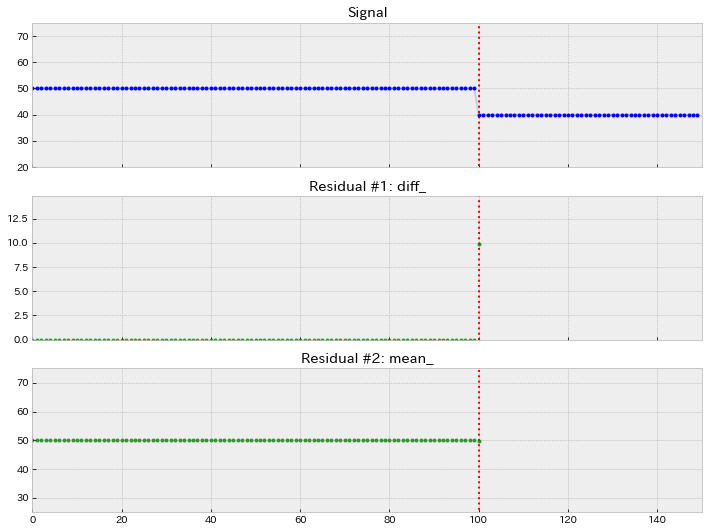

In [65]:
detector = MeanDetector(threshold=.05)
OnlineSimulator(detector, sig1).run()

## noise

Residuals: ['diff_', 'mean_']
Change detected. Stopping Rule triggered at 100.



True

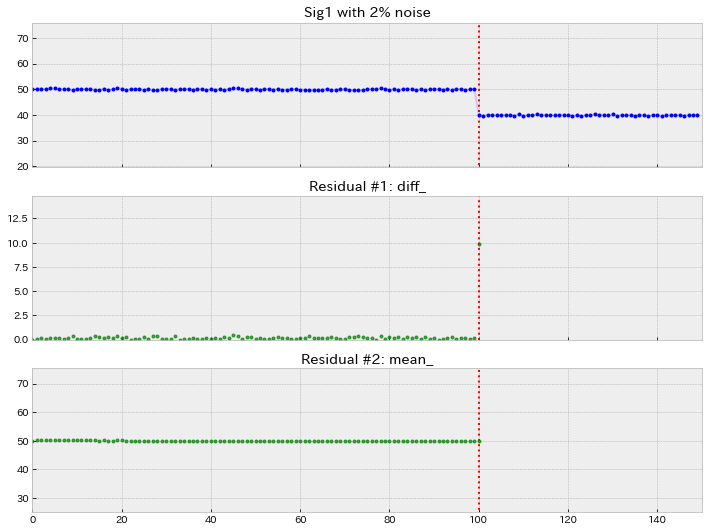

In [66]:
jump_size = sig1[0] - sig1[-1]

# We'll add a small amount (0.02 x jump_size) of Gaussian noise to the signal. 
noise = np.random.normal(
    size=sig1.shape,
    scale=jump_size * 0.02)

detector = MeanDetector(threshold=0.05)

OnlineSimulator(detector, sig1 + noise).run(signal_name='Sig1 with 2% noise')

## more noise

Residuals: ['diff_', 'mean_']
Change detected. Stopping Rule triggered at 30.



True

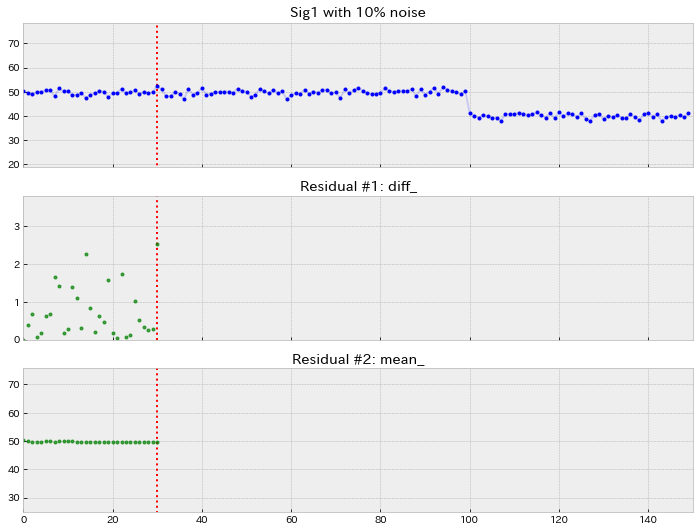

In [67]:
# 10% noise sometimes causes trouble
noise = np.random.normal(
    size=sig1.shape,
    scale=jump_size * 0.10)

detector = MeanDetector(threshold=0.05)
OnlineSimulator(detector, sig1 + noise).run(signal_name='Sig1 with 10% noise')

Residuals: ['diff_', 'mean_']
Change detected. Stopping Rule triggered at 9.



True

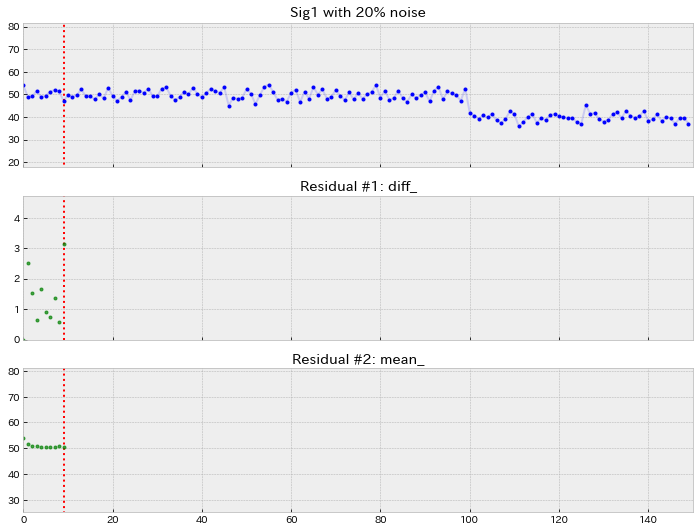

In [68]:
# 20% noise pretty much always causes problems
noise = np.random.normal(
    size=sig1.shape,
    scale=jump_size * 0.20)

detector = MeanDetector(threshold=0.05)

OnlineSimulator(detector, sig1 + noise).run(signal_name='Sig1 with 20% noise')

# Section 3

## seasonality

Text(0.5,1,'Imaginary Seasonal signal')

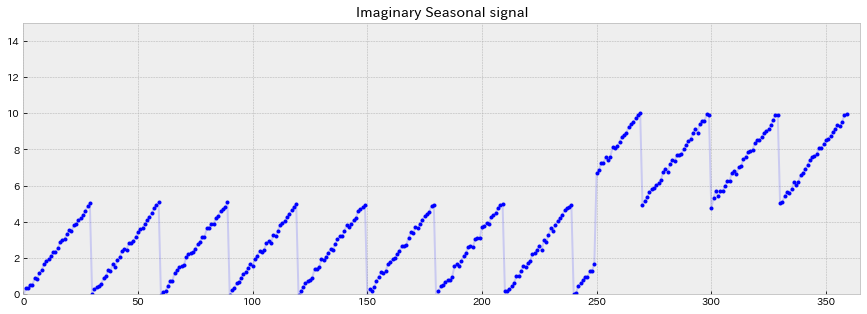

In [70]:
sig = np.linspace(0, 5, num=30)
sig = np.concatenate([sig for _ in range(12)])

# Add a jump
jump_size = 5
sig[250:] = sig[250:] + jump_size

# Noise
noise = np.random.normal(
    size=sig.shape,
    scale=jump_size * 0.02)

plt.figure(figsize=(15,5))
plt.plot(sig + noise, 'b.', linestyle='')
plt.plot(sig + noise, 'b-', alpha=0.15)
plt.ylim(0,15)
plt.xlim(0,365)
plt.title("Imaginary Seasonal signal")

In [82]:
from collections import deque
class ZScoreDetector(ChangeDetector):
    def __init__(self, window_size=100, threshold=0.05):
        super().__init__()
        self.threshold = threshold
        self.window_size = window_size
        
        self.k = 0 # total signal size
        self.g_mean = 0.
        self.s =0.
        
        self.window = deque(maxlen=window_size)
        
        self.z_score_ = np.nan
        self.z_array = []
        
    def update_residuals(self, new_signal_value):
        self._update_base_residuals(new_signal_value)
        x = new_signal_value
        self.k += 1
        
        self.window.append(x)
        oldm = self.g_mean
        newm = oldm + (x-oldm) / (self.k)
        self.s = self.s + (x - newm) * (x-oldm)
        
        g_mean  = newm
        g_std = np.sqrt(self.s / self.k)
        
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)
        
        std_diff = (g_std - w_std) / g_std
        se =g_std / np.sqrt(self.window_size)
        
        mean_diff = (g_mean - w_mean) / g_mean
        
        self.z_score_ = (w_mean - g_mean) / se
        self.z_array.append(self.z_score_)
        
        self.g_mean = g_mean
    
    def check_stopping_rules(self, new_signal_value):
        if np.abs(self.z_score_) > self.threshold:
            self.rules_triggered = True

Residuals: ['z_score_']
Change detected. Stopping Rule triggered at 109.



/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


True

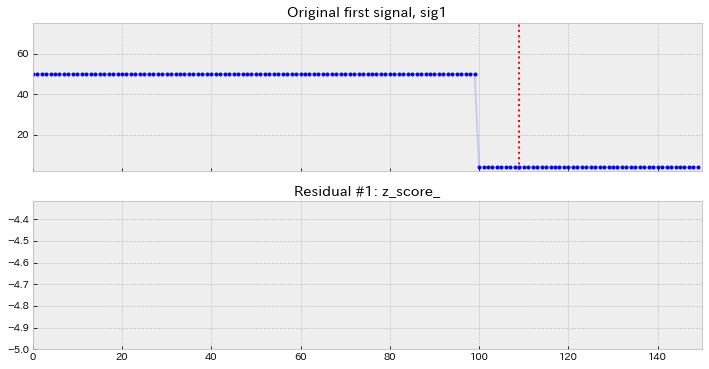

In [83]:
basic_sig = np.ones(150)
basic_sig[:100] *= 50
basic_sig[100:] *= 4

# On Signal 1
detector = ZScoreDetector(window_size = 10, threshold=10.0)
OnlineSimulator(detector, basic_sig).run(
     signal_name='Original first signal, sig1'
     )

Residuals: ['z_score_']
Change detected. Stopping Rule triggered at 276.



/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


True

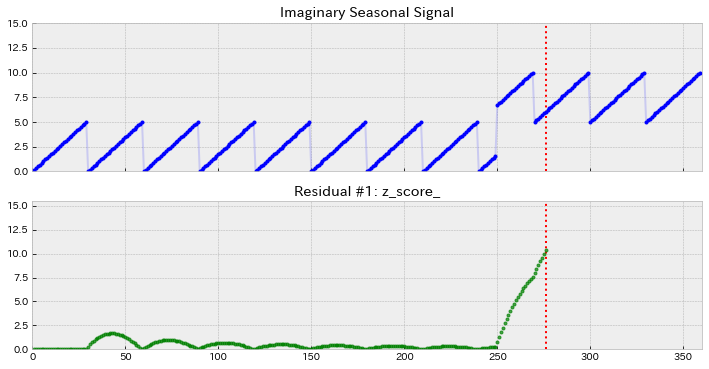

In [84]:
detector = ZScoreDetector(window_size = 30, threshold=10.0)
OnlineSimulator(detector, sig).run(signal_name = "Imaginary Seasonal Signal")

Residuals: ['z_score_']
Change detected. Stopping Rule triggered at 138.



/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


True

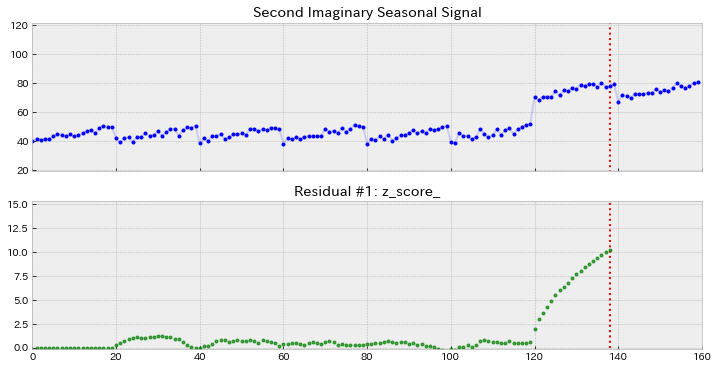

In [86]:
jump_size = 30

sig2 = np.linspace(40, 50, num=20)
sig2 = np.concatenate([sig2 for _ in range(8)])

# TODO need a change to detect
sig2[120:] = sig2[120:] + jump_size

noise = np.random.normal(
    size=sig2.shape,
    scale=jump_size * 0.05
    )

sig2 = sig2 + noise


detector = ZScoreDetector(window_size = 20, threshold=10.0)
OnlineSimulator(detector, sig2).run(signal_name = "Second Imaginary Seasonal Signal")

## outlier

(0, 100)

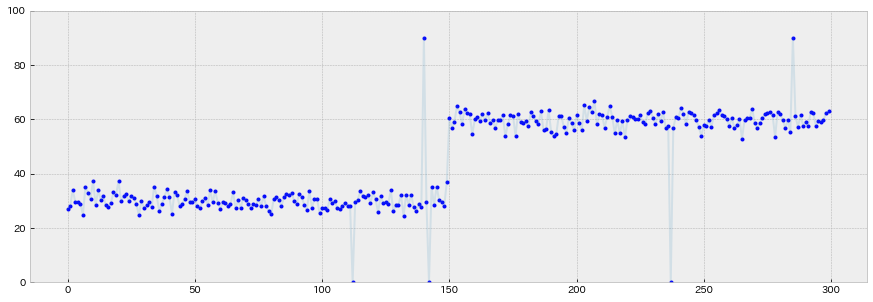

In [87]:
ump_size = 20
signal_size = 300

# Create a signal with a small jump (change)
sig3 = np.ones(signal_size)
sig3[:150] = 30
sig3[150:] = 30 + jump_size

# Add noise
noise = np.random.normal(
    scale = 0.10 * jump_size,
    size=signal_size)

sig3 = sig3 + noise

# Add outliers
outlier_idx = np.random.choice(signal_size, size=3)
sig3[outlier_idx] = 0
outlier_idx = np.random.choice(signal_size, size=2)
sig3[outlier_idx] = 90

# What does this  look like?
plt.figure(figsize=(15, 5))
plt.plot(sig3, 'b.')
plt.plot(sig3, '-', alpha=0.15)
plt.ylim(0,100)

Residuals: ['z_score_']
Change detected. Stopping Rule triggered at 174.



/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


True

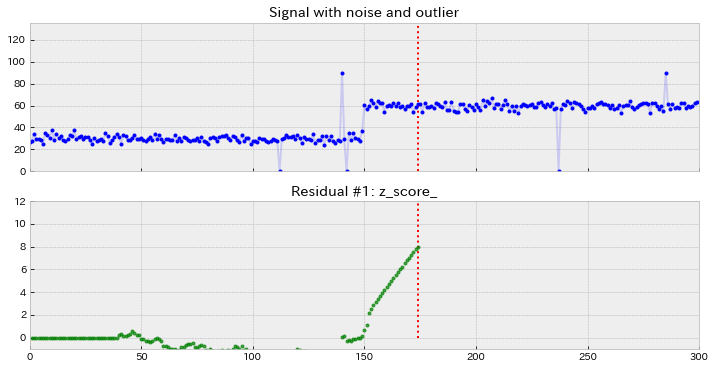

In [88]:
detector = ZScoreDetector(window_size = 40, threshold=8.0)
OnlineSimulator(detector, sig3).run(signal_name = "Signal with noise and outlier")